In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, MultiPolygon
import datetime 
from scipy.stats import kde
from scipy.stats import gaussian_kde
import geopandas as gpd
from scipy import stats

import rasterio
from rasterio.features import rasterize
from affine import Affine

proj = ccrs.PlateCarree()

#External functions 
import fct.fct_link_storm_claim as fct_link_storm_claim
import fct.preprocess_sinclim as preprocess_sinclim
import fct.fct_plot_claims as fct_plot_claims
from fct.paths import *

path_save_fig = PATH_FIGURE+"Track_analysis/"
path_save_data = PATH_GENERALI+"storm_density/"

In [3]:
period = "1979-2024WIN"
df_info_storm                       = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm                            = pd.read_csv(PATH_TRACKS+"tracks_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm.storm_id.nunique()} number of storms")

df_info_storm_FR                       = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+"_info.csv", encoding='utf-8')
df_info_storm_FR['storm_landing_date'] = pd.to_datetime(df_info_storm_FR['storm_landing_date'])
df_storm_FR                            = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_"+period+".csv", encoding='utf-8')
print(f"{df_info_storm_FR.storm_id.nunique()} number of storms - FR")

# df_info_storm_SSI = pd.read_csv(PATH_TRACKS+"tracks_FR_ALL_24h_1979-2024WIN_info_SSI-wgust-q98_r1300.csv", encoding="utf-8")
# df_info_storm_SSI = df_info_storm_SSI.rename(columns={'SSI_FRA_wgust_q98' : "SSI_FRA"})
# df_info_storm = pd.merge(df_info_storm, df_info_storm_SSI[['storm_id', 'SSI_FRA']], on='storm_id')

########## IMPACT DATA 
window              = 'd-3_d+3'
min_claim           = 50
method              = 'wgust'
r_sinclim           = 1300
r_varying           = False
sinclim_version     = "v2.2"
sinclim_date        = "v200126"
sinclim_peril       = "storm" #"storm" # "storm_extended"

sinclim = preprocess_sinclim.open_sinclim_associated(PATH_GENERALI, sinclim_version, sinclim_peril, sinclim_date, window, min_claim, method, "1997-2024", r_sinclim, False)
stormi_impact = sinclim.storm_id.unique()

df_info_storm_impact = df_info_storm.loc[df_info_storm.storm_id.isin(stormi_impact)]
df_storm_impact      = df_storm.loc[df_storm.storm_id.isin(stormi_impact)]
print(f"{df_info_storm_impact.storm_id.nunique()} storms with impact")

#Add storm_landing date and SSI
sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')

#Load clusters 
windi      = 96
r_cluster  = 700

r_part_sinclim = f"r-varying" if r_varying else f"r{r_sinclim}"
r_part_clust = f"_r{r_cluster}" if r_cluster is not None else ""
fname_cluster = f"tracks_FR_ALL_24h_impact_{sinclim_version}_{sinclim_peril}_{window}-unique-{method}_min{min_claim}_{r_part_sinclim}_{sinclim_date}_clust-mult-2storms-{windi}h{r_part_clust}_{period}"
df_storm_cluster_test                            = pd.read_csv(PATH_TRACKS+fname_cluster+".csv", encoding='utf-8')
df_info_mult_cluster_test                       = pd.read_csv(PATH_TRACKS+fname_cluster+"_info.csv", encoding='utf-8')
df_info_mult_cluster_test['storm_landing_date'] = pd.to_datetime(df_info_mult_cluster_test['storm_landing_date'])

#Indiviudal storms 
df_storm_indiv = df_storm_impact[~df_storm_impact["storm_id"].isin(df_info_mult_cluster_test["storm_id"].unique())]
df_info_storm_indiv = df_info_storm_impact[~df_info_storm_impact["storm_id"].isin(df_info_mult_cluster_test["storm_id"].unique())]

9881 number of storms
4439 number of storms - FR
322 storms with impact


In [4]:
# Convert to ERA5 Grid
grid_lat = np.arange(40, 60.25, 0.25)
grid_lon = np.arange(-10, 15.25, 0.25)
sinclim_025 = preprocess_sinclim.grid_df(sinclim, grid_lat, grid_lon, "num_lat", "num_lon")
sinclim_025_xr = sinclim_025.groupby(['latitude', 'longitude', 'storm_id']).agg(nb_claims = ('num_chg_brut_cst', 'count'), 
                                                                        mean_chg_brut_cst = ('num_chg_brut_cst', 'sum'), 
                                                                        wgust = ('wgust_max', "max")).to_xarray()
sinclim_025_xr = preprocess_sinclim.add_wind_quantiles_era5_xr(sinclim_025_xr)
sinclim_025 = sinclim_025_xr.to_dataframe().reset_index()

In [5]:
######## Group the impact data over storm events
# sinclim = sinclim.loc[sinclim.storm_id.isin(df_info_storm_impact.storm_id.unique())]
# sinclim = pd.merge(sinclim, df_info_storm_impact, on='storm_id', how='left')
sinclim_storm = sinclim.groupby(['storm_id']).agg(
    num_chg_brut =('num_chg_brut_cst', 'sum'), 
    nb_claims    =('num_chg_brut_cst', 'count'),
    storm_landing_date = ('storm_landing_date', 'first'),
#     NDR_6h_max   =('NDR_6h_max', 'first'), 
#     NDR_24h_max  =('NDR_24h_max', 'first')
).reset_index()#, 
#     SSI_FRA_max = ('SSI_FRA', 'first')).reset_index()

In [6]:
def storm_density_with_buffer(df, nb_norm, res=1.0, radius_km=700):
    # Define grid
    lon_bins = np.arange(df['lon'].min()-res, df['lon'].max()+res, res)
    lat_bins = np.arange(df['lat'].min()-res, df['lat'].max()+res, res)
    lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
    lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
    
    # Grid as points
    lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
    grid_points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(lon_grid.ravel(), lat_grid.ravel()),
        crs="EPSG:4326"
    )
    
    # Storm track points -> GeoDataFrame
    gdf_tracks = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.lon, df.lat),
        crs="EPSG:4326"
    )
    
    H = np.zeros(lon_grid.shape, dtype=float)

    # loop over storms
    for storm_id, df_storm in df.groupby("storm_id"):
        gdf_tracks = gpd.GeoDataFrame(
            df_storm,
            geometry=gpd.points_from_xy(df_storm.lon, df_storm.lat),
            crs="EPSG:4326"
        )
        # buffer around all track points for this storm
        storm_buffer = unary_union(
            gdf_tracks.to_crs(epsg=3395).buffer(radius_km*1000).to_crs(epsg=4326)
        )

        # mask for this storm
        inside_mask = grid_points.geometry.apply(lambda p: storm_buffer.contains(p))

        # add 1 storm to all covered cells
        H += inside_mask.values.reshape(H.shape).astype(int)

    # normalize (e.g., per year)
    H = H / nb_norm
    
    return H, lon_centers, lat_centers

In [7]:
# def storm_density_with_buffer(df, nb_norm, res=1.0, radius_km=700):

#     # --- grid definition ---
#     lon_min, lon_max = df.lon.min()-res, df.lon.max()+res
#     lat_min, lat_max = df.lat.min()-res, df.lat.max()+res

#     lon_centers = np.arange(lon_min, lon_max, res)
#     lat_centers = np.arange(lat_min, lat_max, res)

#     nlon = len(lon_centers)
#     nlat = len(lat_centers)

#     H = np.zeros((nlat, nlon), dtype=float)

#     # affine transform (pixel grid)
#     transform = Affine.translation(lon_min, lat_max) * Affine.scale(res, -res)

#     # project once
#     gdf = gpd.GeoDataFrame(
#         df,
#         geometry=gpd.points_from_xy(df.lon, df.lat),
#         crs="EPSG:4326"
#     ).to_crs(epsg=3395)

#     # loop storms
#     for storm_id, g in gdf.groupby("storm_id"):

#         buffer_geom = unary_union(g.geometry.buffer(radius_km * 1000))

#         burned = rasterize(
#             [(buffer_geom, 1)],
#             out_shape=H.shape,
#             transform=transform,
#             fill=0,
#             all_touched=True,
#             dtype="uint8"
#         )

#         H += burned

#     return H / nb_norm, lon_centers, lat_centers

In [10]:
def plot_density_winter_circle_area(ax, df, nb_years, title, cmap, tracks=False, radius_km=700, res=1.0):
    # Define grid
#     res = 1.0
#     lon_bins = np.arange(df['lon'].min()-res, df['lon'].max()+res, res)
#     lat_bins = np.arange(df['lat'].min()-res, df['lat'].max()+res, res)
    
    H, lon_centers, lat_centers = storm_density_with_buffer(df, nb_years, res=res, radius_km=radius_km)

    mesh = ax.contourf(
        lon_centers, lat_centers, H,
        levels=20, cmap=cmap, extend="max",
        transform=ccrs.PlateCarree()
    )
    
    if tracks : 
        for stormi in df_storm_impact.storm_id.unique() :
            ax.plot(df_storm_impact.loc[df_storm_impact.storm_id==stormi]["lon"], df_storm_impact.loc[df_storm_impact.storm_id==stormi]["lat"], 
                    color="gray", alpha=0.3)
    
    # Add features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.7)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5)

    ax.set_extent([-80, 20, 30, 65], crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=18, fontweight="bold")

    # Add individual colorbar with bigger text
    cbar = plt.colorbar(mesh, ax=ax, orientation="horizontal", fraction=0.05, pad=0.1)
    cbar.ax.tick_params(labelsize=14)  # tick labels
    cbar.set_label("Avg. storm track points per winter", fontsize=16, fontweight="bold")

    return mesh

In [14]:
# Custom colormap: YlOrRd but white at 0
cmap = cm.get_cmap("YlOrRd")
cmap_colors = cmap(np.arange(cmap.N))
cmap_colors[0] = [1, 1, 1, 1]  # force first color to white
cmap_custom = colors.ListedColormap(cmap_colors)

# Number of years
nb_years = 2024 - 1979

# Make 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(3):
    axes[i]._autoscaleXon = False
    axes[i]._autoscaleYon = False

r = 700
res=1
plot_density_winter_circle_area(axes[0], df_storm, nb_years, f"(a) All Storms (n={df_storm.storm_id.nunique()})", cmap_custom, r, res=res)
plot_density_winter_circle_area(axes[1], df_storm_impact, nb_years, f"(b) Storms with Impact (n={df_storm_impact.storm_id.nunique()})", cmap_custom, r, res=res)
plot_density_winter_circle_area(axes[2], df_storm_cluster_test, nb_years, f"(c) Clustered Storms (n={df_storm_cluster_test.storm_id.nunique()})", cmap_custom, r, res=res)
fig .tight_layout()

# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.svg", 
#             format="svg", bbox_inches="tight", dpi=300, transparent=True)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.pdf", 
#             format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

<ipython-input-14-600e3fc14fe2>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")


NameError: name 'colors' is not defined

<ipython-input-14-563f28e28c69>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")


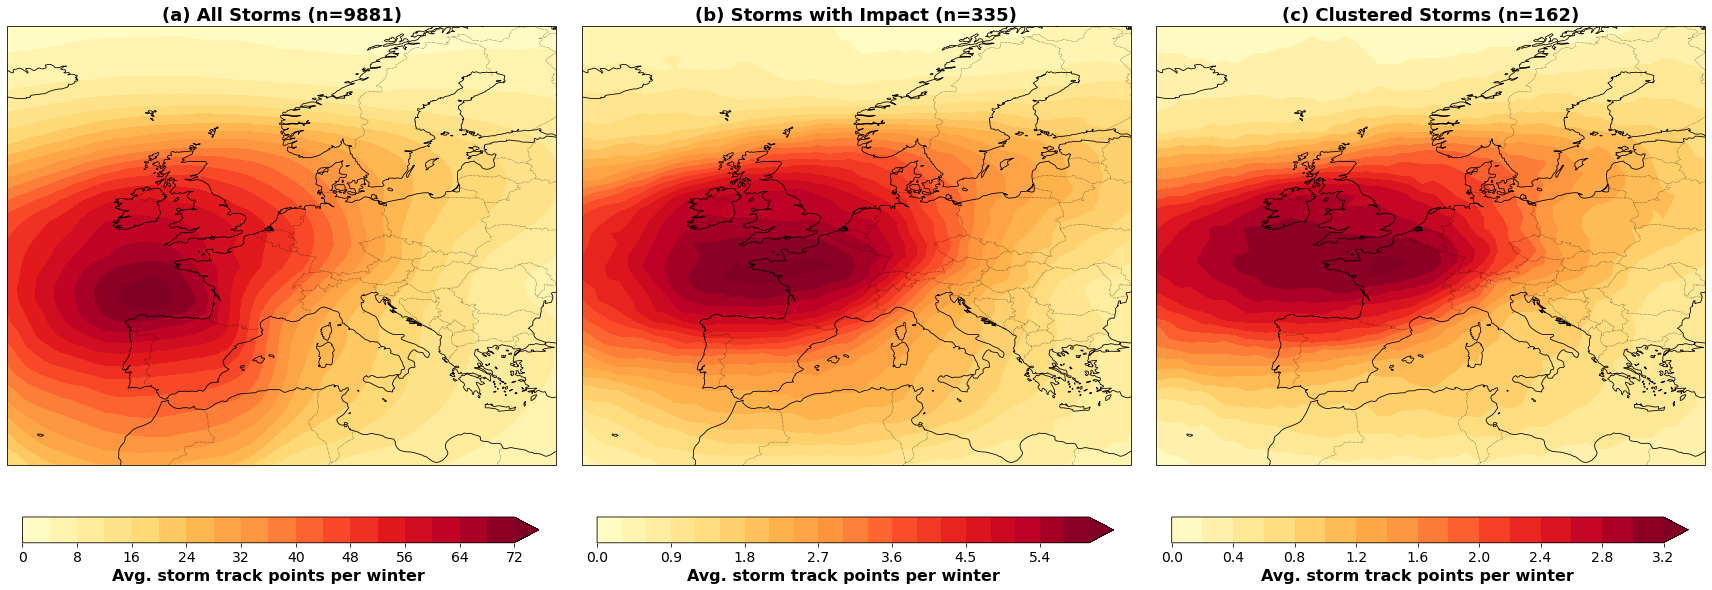

In [14]:
# Custom colormap: YlOrRd but white at 0
cmap = cm.get_cmap("YlOrRd")
cmap_colors = cmap(np.arange(cmap.N))
cmap_colors[0] = [1, 1, 1, 1]  # force first color to white
cmap_custom = colors.ListedColormap(cmap_colors)

# Number of years
nb_years = 2024 - 1979

# Make 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(3):
    axes[i]._autoscaleXon = False
    axes[i]._autoscaleYon = False

r = 1300
res=1
plot_density_winter_circle_area(axes[0], df_storm, nb_years, f"(a) All Storms (n={df_storm.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[1], df_storm_impact, nb_years, f"(b) Storms with Impact (n={df_storm_impact.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[2], df_storm_cluster_test, nb_years, f"(c) Clustered Storms (n={df_storm_cluster_test.storm_id.nunique()})", cmap_custom, False, r, res)
fig .tight_layout()

# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.svg", 
#             format="svg", bbox_inches="tight", dpi=300, transparent=True)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.pdf", 
#             format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

# Genesis 

In [10]:
df_genesis = {}
# subsets = ["All", "France", "Impact", "Cluster"]
# dfs = [df_storm, df_storm_FR, df_storm_impact, df_storm_cluster_test]

subsets = ["France", "Individual", "Cluster"]
dfs = [df_storm_FR, df_storm_indiv, df_storm_cluster_test]

for subset, df in zip(subsets, dfs) : 
    df['time'] = pd.to_datetime(
        dict(
            year=df['year'],
            month=df['month'],
            day=df['day'],
            hour=df['hour']
        )
    )
    df_genesis_subset = (
        df.sort_values('time')
          .groupby('storm_id', as_index=False)
          .first()
    )
    df_genesis[subset] = df_genesis_subset 

<ipython-input-10-75c27aa50ea3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(


<ipython-input-34-1d50ead319e3>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlGnBu")
<ipython-input-34-1d50ead319e3>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")


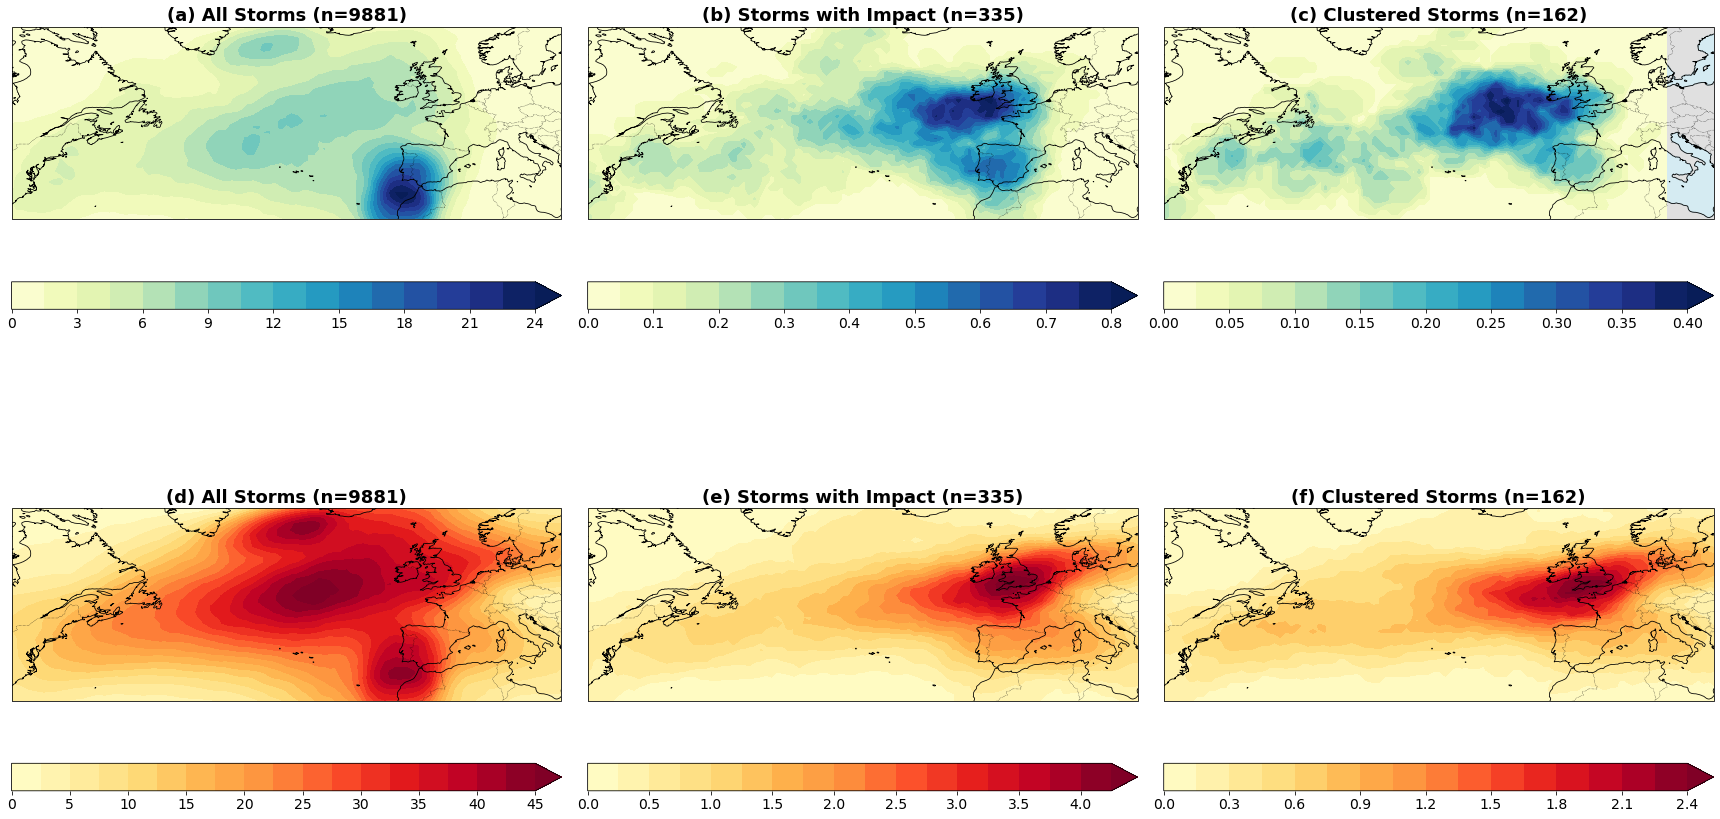

In [34]:
# Number of years
nb_years = 2024 - 1979

# Make 3 side-by-side plots
fig, axes = plt.subplots(2, 3, figsize=(24, 16), subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(2):
    for j in range(3) : 
        axes[i,j]._autoscaleXon = False
        axes[i,j]._autoscaleYon = False

r = 700
res=1

# Genesis 
cmap = cm.get_cmap("YlGnBu")
cmap_colors = cmap(np.arange(cmap.N))
cmap_colors[0] = [1, 1, 1, 1]  # force first color to white
cmap_custom = mcolors.ListedColormap(cmap_colors)

plot_density_winter_circle_area(axes[0,0], df_genesis["All"], nb_years, f"(a) All Storms (n={df_storm.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[0,1], df_genesis["Impact"], nb_years, f"(b) Storms with Impact (n={df_storm_impact.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[0,2], df_genesis["Cluster"], nb_years, f"(c) Clustered Storms (n={df_storm_cluster_test.storm_id.nunique()})", cmap_custom, False, r, res)

# Track density 
cmap = cm.get_cmap("YlOrRd")
cmap_colors = cmap(np.arange(cmap.N))
cmap_colors[0] = [1, 1, 1, 1]  # force first color to white
cmap_custom = mcolors.ListedColormap(cmap_colors)

plot_density_winter_circle_area(axes[1,0], df_storm, nb_years, f"(d) All Storms (n={df_storm.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[1,1], df_storm_impact, nb_years, f"(e) Storms with Impact (n={df_storm_impact.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[1,2], df_storm_cluster_test, nb_years, f"(f) Clustered Storms (n={df_storm_cluster_test.storm_id.nunique()})", cmap_custom, False, r, res)


fig.tight_layout()

# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.png", 
#             transparent=True, bbox_inches='tight', dpi=300)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.svg", 
#             format="svg", bbox_inches="tight", dpi=300, transparent=True)
# fig.savefig(path_save_fig+f"storm_density_per_winter_r{r}_res{res}.pdf", 
#             format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

<ipython-input-11-c4a16493eb8a>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")


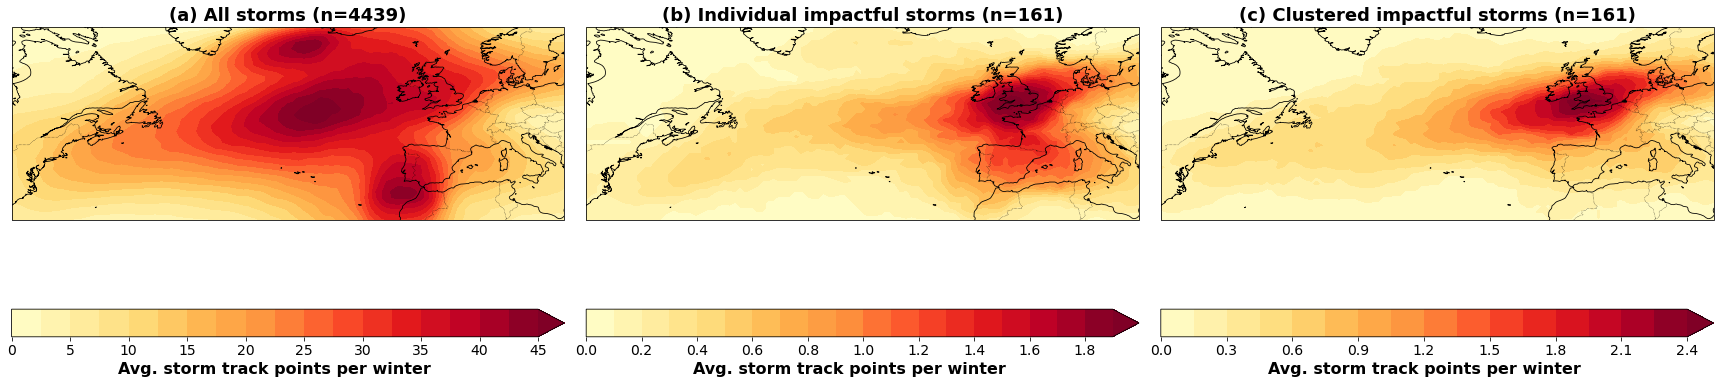

In [11]:
# Number of years
nb_years = 2024 - 1979

# Make 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 13), subplot_kw={'projection': ccrs.PlateCarree()})
for j in range(3) : 
    axes[j]._autoscaleXon = False
    axes[j]._autoscaleYon = False

r = 700
res = 1

# Track density 
cmap = cm.get_cmap("YlOrRd")
cmap_colors = cmap(np.arange(cmap.N))
cmap_colors[0] = [1, 1, 1, 1]  # force first color to white
cmap_custom = mcolors.ListedColormap(cmap_colors)

plot_density_winter_circle_area(axes[0], df_storm, nb_years, f"(a) All storms (n={df_storm_FR.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[1], df_storm_indiv, nb_years, f"(b) Individual impactful storms (n={df_storm_indiv.storm_id.nunique()})", cmap_custom, False, r, res)
plot_density_winter_circle_area(axes[2], df_storm_cluster_test, nb_years, f"(c) Clustered impactful storms (n={df_storm_cluster_test.storm_id.nunique()})", cmap_custom, False, r, res)

fig.tight_layout()

fig.savefig(path_save_fig+f"storm_density_per_winter_indiv-clust_r{r}_res{res}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"storm_density_per_winter_indiv-clust_r{r}_res{res}.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+f"storm_density_per_winter_indiv-clust_r{r}_res{res}.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()

# Track characteristics

In [11]:
def compute_storm_stats(df):
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"])

    out = (
        df.groupby("storm_id")
          .agg(
              minslp=("slp", "min"),
              maxvo=("vo_max", "max"),
              duration_hours=("time", lambda x: (x.max() - x.min()).total_seconds() / 3600)
          )
          .reset_index()
    )
    return out

In [12]:
storm_stats = [compute_storm_stats(df) for df in dfs]

TypeError: 'module' object is not iterable

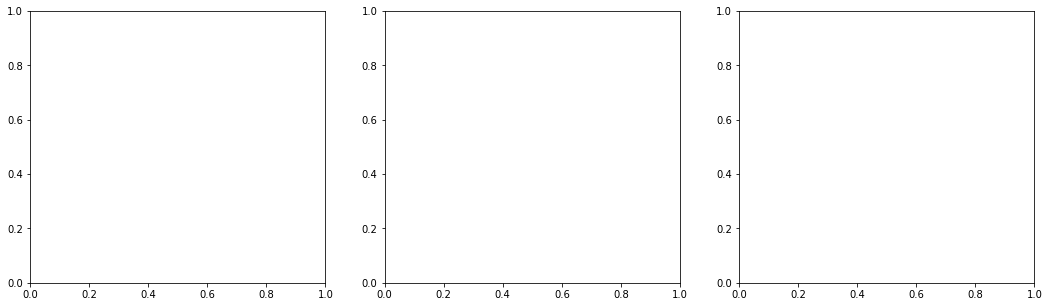

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
nbins=5

# --- Min SLP ---
for s, lab in zip(stats, subsets):
    axes[0].hist(
        s["minslp"],
        bins=nbins,
        density=True,
        histtype="step",
        linewidth=1.5,
        label=lab,
    )

axes[0].set_xlabel("Minimum SLP per storm")
axes[0].set_ylabel("Probability density")
axes[0].set_title("Min SLP")

# --- Max VO ---
for s, lab in zip(stats, subsets):
    axes[1].hist(
        s["maxvo"],
        bins=nbins,
        density=True,
        histtype="step",
        linewidth=1.5,
        label=lab,
    )

axes[1].set_xlabel("Maximum VO per storm")
axes[1].set_title("Max VO")

# --- Duration ---
for s, lab in zip(stats, subsets):
    axes[2].hist(
        s["duration_hours"],
        bins=nbins,
        density=True,
        histtype="step",
        linewidth=1.5,
        label=lab,
    )

axes[2].set_xlabel("Duration (hours)")
axes[2].set_title("Storm Duration")
axes[2].legend()

plt.tight_layout()
plt.show()

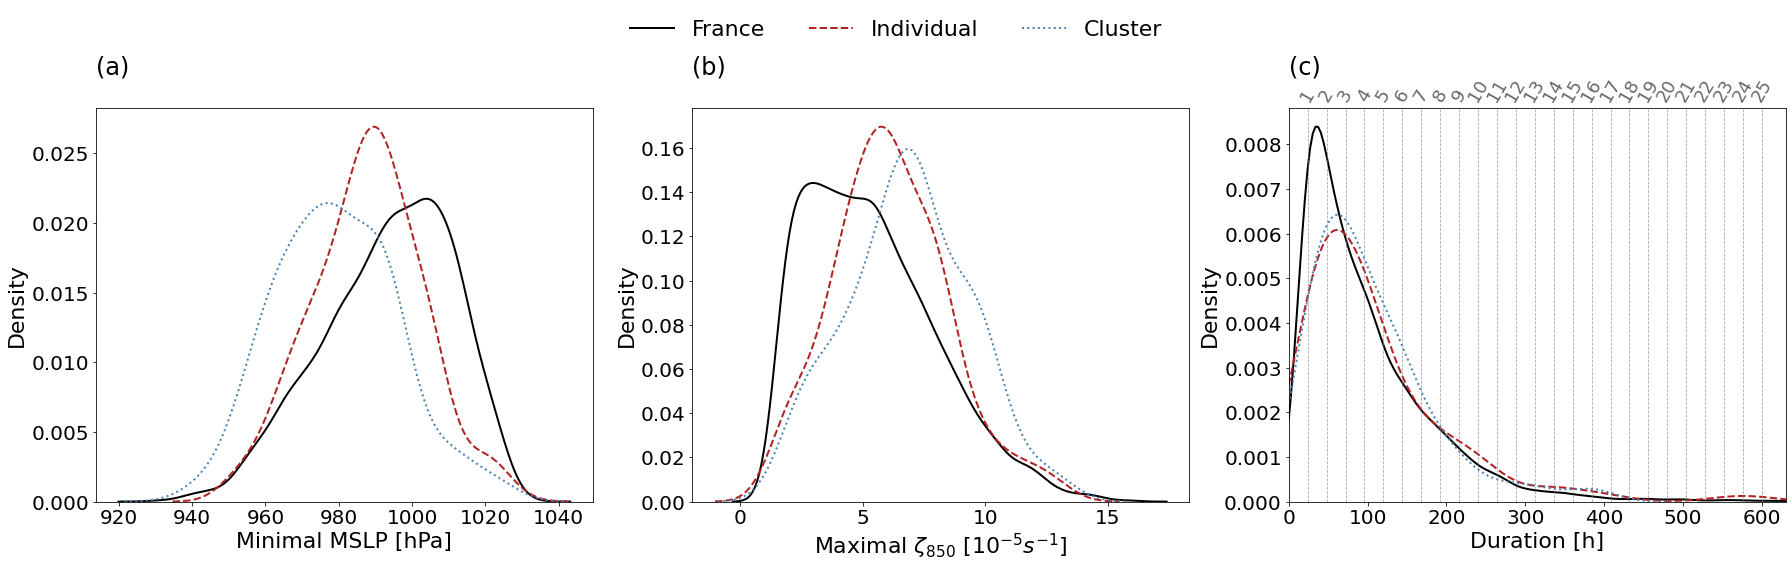

In [47]:
# Darker color palette
base_colors = sns.color_palette("dark", 3)
color_map = {
    "Cluster": "#4682b4",   # steel blue
    "Individual": "#b22222", # firebrick red
    "France": "black"
}

linestyle_map = {
    "Cluster": ":",        # solid
    "Individual": "--",    # dashed
    "France": "-"          # dotted
}

fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=False)
fontsize = 22
ticksize = 20

# --- Min SLP ---
for (s, lab) in zip(storm_stats, subsets):
    sns.kdeplot(s["minslp"]/100, ax=axes[0], label=lab, linewidth=2, color=color_map[lab], linestyle=linestyle_map[lab])
axes[0].set_title("(a)", loc="left", fontsize=fontsize+2, y=1.07)
axes[0].set_xlabel("Minimal MSLP [hPa]", fontsize=fontsize)
axes[0].set_ylabel("Density", fontsize=fontsize)


# --- Max VO ---
for (s, lab) in zip(storm_stats, subsets):
    sns.kdeplot(s["maxvo"], ax=axes[1], linewidth=2, color=color_map[lab], linestyle=linestyle_map[lab])
axes[1].set_title("(b)", loc="left", fontsize=fontsize+2, y=1.07)
axes[1].set_xlabel(r"Maximal $\zeta_{850}$ [$10^{-5}s^{-1}$]", fontsize=fontsize)
axes[1].set_ylabel("Density", fontsize=fontsize)


# --- Duration ---
for (s, lab) in zip(storm_stats, subsets):
    sns.kdeplot(
    s["duration_hours"],
    ax=axes[2],
    linewidth=2,
    clip=(0, None),
    color=color_map[lab], 
    linestyle=linestyle_map[lab]
    )
axes[2].set_title("(c)", loc="left", fontsize=fontsize+2, y=1.07)
axes[2].set_xlabel("Duration [h]", fontsize=fontsize)
axes[2].set_ylabel("Density", fontsize=fontsize)
axes[2].set_xlim(left=0, right=400)
# axes[2].set_xlim(left=0)

# --- Add thin vertical lines every 24h ---
max_duration = max(s["duration_hours"].max() for s in storm_stats) # get the max value
axes[2].set_xlim(left=0, right=max_duration)
for day in range(1, int(max_duration/24)): # +2 to ensure the last line is included
    axes[2].axvline(x=24*day, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# --- Label the day numbers on top
for day in range(1, int(max_duration/24)):
    axes[2].text(24*day, axes[2].get_ylim()[1]*1.01, f"{day}", rotation=60, ha='center', va='bottom', fontsize=ticksize-2, color='dimgray')

# --- Tick label size for all subplots ---
for ax in axes:
    ax.tick_params(axis='both', labelsize=ticksize)


# --- One shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(subsets), fontsize=fontsize, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.92])

fig.savefig(path_save_fig+f"Distribution-physical-characteristics-clust-indiv_{method}-{window}-min{min_claim}_r{r_sinclim}.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+f"Distribution-physical-characteristics-clust-indiv_{method}-{window}-min{min_claim}_r{r_sinclim}.pdf", 
            format="pdf", transparent=True, bbox_inches='tight', dpi=300)

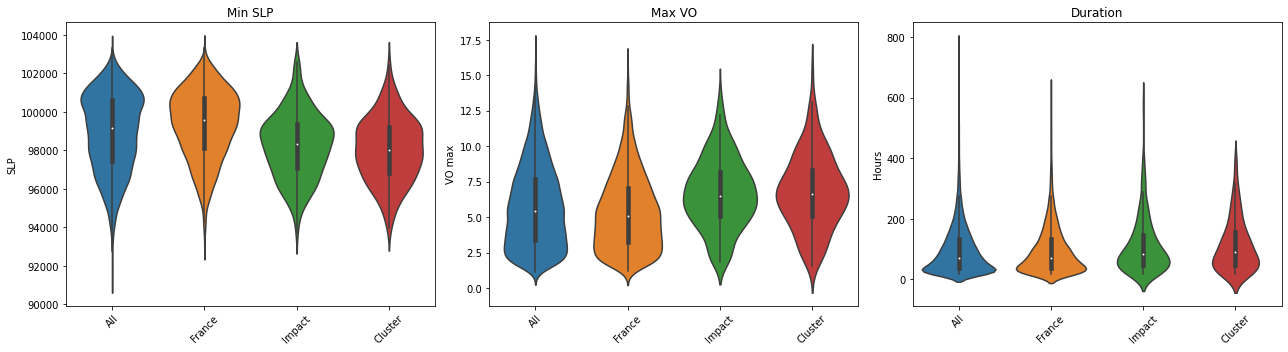

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Prepare data for violin plots ---
# Each list contains one series per dataset
minslp_data = [s["minslp"] for s in stats]
maxvo_data = [s["maxvo"] for s in stats]
duration_data = [s["duration_hours"] for s in stats]

# Min SLP
sns.violinplot(data=minslp_data, ax=axes[0])
axes[0].set_xticklabels(subsets, rotation=45)
axes[0].set_title("Min SLP")
axes[0].set_ylabel("SLP")

# Max VO
sns.violinplot(data=maxvo_data, ax=axes[1])
axes[1].set_xticklabels(subsets, rotation=45)
axes[1].set_title("Max VO")
axes[1].set_ylabel("VO max")

# Duration
sns.violinplot(data=duration_data, ax=axes[2])
axes[2].set_xticklabels(subsets, rotation=45)
axes[2].set_title("Duration")
axes[2].set_ylabel("Hours")

plt.tight_layout()
plt.show()

# Special impact for Generali

In [47]:
import os
import numpy as np
import datetime
import xarray as xr
import matplotlib.pyplot as plt

# ---- Function from your snippet ----
def import_wgust_footprint(sinclim_storm, r=1300, path_footprint_wgust=PATH_FOOTPRINTS):
    datasets_storm = []

    for stormi in np.unique(sinclim_storm.storm_id):
        # Convert storm_id to datetime (optional if needed)
        date_stormi_loop = datetime.datetime.strptime(stormi[:19], "%Y-%m-%d %H:%M:%S")

        stormi_path = os.path.join(path_footprint_wgust, stormi + f"_max_r{r}.nc")
        ds = xr.open_mfdataset(stormi_path, engine="netcdf4").drop_vars('time', errors='ignore')

        # Add storm_id dimension
        ds = ds.expand_dims({'storm_id': [stormi]})
        datasets_storm.append(ds)

    combined_dataset_storm = xr.concat(datasets_storm, dim='storm_id')    
    return combined_dataset_storm


# ---- 1. Load footprints ----
footprints = import_wgust_footprint(sinclim_storm)

In [48]:
# ---- 2. Load the 95th percentile climatology ----
q = 90
ds_q95 = xr.open_mfdataset(
    PATH_WGUST_QUANTILE + f"windgust_percentile-q{q}_1950_2022_winter.nc",
    chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
).mean('time')  # Take climatology (no time dimension)

In [38]:
# ---- 3. Normalize footprints ----
# Assuming footprint variable is named "wind_gust" (adapt to your variable name!)
var = [v for v in footprints.data_vars][0]  # pick first var if not sure
norm = footprints[var] / ds_q95["fg10"]

# ---- 4. Count exceedances ----
exceedances = (norm > 1).sum(dim='storm_id')

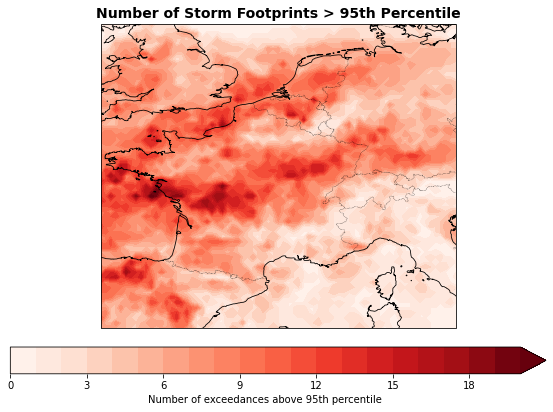

In [46]:
# ---- Plot ----
fig, ax = plt.subplots(
    figsize=(12, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax._autoscaleXon = False 
ax._autoscaleYon = False

# Filled contour plot
cmap = plt.cm.Reds
mesh = ax.contourf(
    exceedances.longitude, exceedances.latitude, exceedances.sel(time=0),
    levels=20, cmap=cmap, extend="max",
    transform=ccrs.PlateCarree()
)

# Background features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.7, zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5, zorder=0)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)
cbar.set_label(f"Number of exceedances above {q}th percentile")

#Center around France 
ax.set_extent([-5, 12.5, 40, 55], crs=ccrs.PlateCarree())

# Title
ax.set_title(f"Number of Storm Footprints > {q}th Percentile", fontsize=14, weight="bold")

plt.show()

In [ ]:
# ---- 2. Load the 95th percentile climatology ----
q = 90
ds_q95 = xr.open_mfdataset(
    PATH_WGUST_QUANTILE + f"windgust_percentile-q{q}_1950_2022_winter.nc",
    chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
).mean('time')  # Take climatology (no time dimension)

In [49]:
# ---- 3. Normalize footprints ----
# Assuming footprint variable is named "wind_gust" (adapt to your variable name!)
var = [v for v in footprints.data_vars][0]  # pick first var if not sure
norm = footprints[var] / ds_q95["fg10"]

# ---- 4. Count exceedances ----
exceedances = (norm > 1).sum(dim='storm_id')

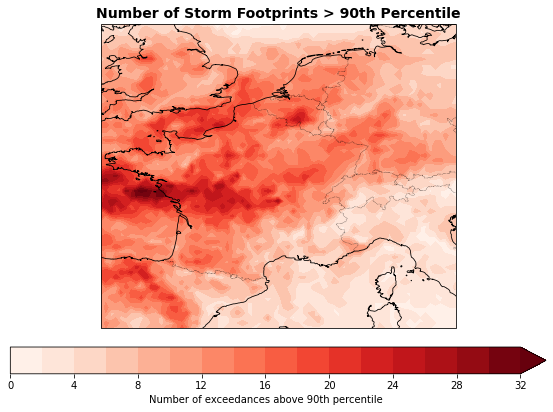

In [50]:
# ---- Plot ----
fig, ax = plt.subplots(
    figsize=(12, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax._autoscaleXon = False 
ax._autoscaleYon = False

# Filled contour plot
cmap = plt.cm.Reds
mesh = ax.contourf(
    exceedances.longitude, exceedances.latitude, exceedances.sel(time=0),
    levels=20, cmap=cmap, extend="max",
    transform=ccrs.PlateCarree()
)

# Background features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.7, zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5, zorder=0)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)
cbar.set_label(f"Number of exceedances above {q}th percentile")

#Center around France 
ax.set_extent([-5, 12.5, 40, 55], crs=ccrs.PlateCarree())

# Title
ax.set_title(f"Number of Storm Footprints > {q}th Percentile", fontsize=14, weight="bold")

plt.show()

In [51]:
# ---- 2. Load the 95th percentile climatology ----
q = 98
ds_q95 = xr.open_mfdataset(
    PATH_WGUST_QUANTILE + f"windgust_percentile-q{q}_1950_2022_winter.nc",
    chunks={'time': -1, 'latitude': 'auto', 'longitude': 'auto'}
).mean('time')  # Take climatology (no time dimension)

In [52]:
# ---- 3. Normalize footprints ----
# Assuming footprint variable is named "wind_gust" (adapt to your variable name!)
var = [v for v in footprints.data_vars][0]  # pick first var if not sure
norm = footprints[var] / ds_q95["fg10"]

# ---- 4. Count exceedances ----
exceedances = (norm > 1).sum(dim='storm_id')

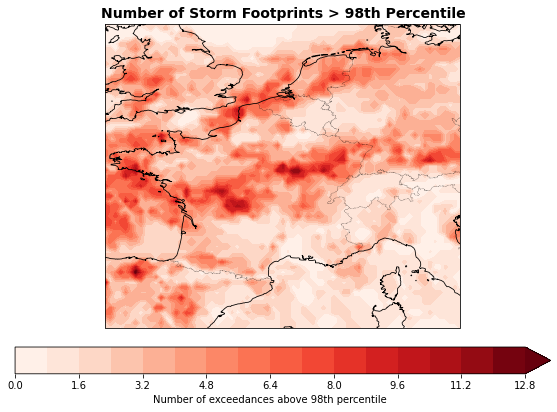

In [53]:
# ---- Plot ----
fig, ax = plt.subplots(
    figsize=(12, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax._autoscaleXon = False 
ax._autoscaleYon = False

# Filled contour plot
cmap = plt.cm.Reds
mesh = ax.contourf(
    exceedances.longitude, exceedances.latitude, exceedances.sel(time=0),
    levels=20, cmap=cmap, extend="max",
    transform=ccrs.PlateCarree()
)

# Background features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.7, zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5, zorder=0)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)
cbar.set_label(f"Number of exceedances above {q}th percentile")

#Center around France 
ax.set_extent([-5, 12.5, 40, 55], crs=ccrs.PlateCarree())

# Title
ax.set_title(f"Number of Storm Footprints > {q}th Percentile", fontsize=14, weight="bold")

plt.show()

# Intensity distribution

In [81]:
df_info_storm_impact.min_slp.iloc[0]

97283.15

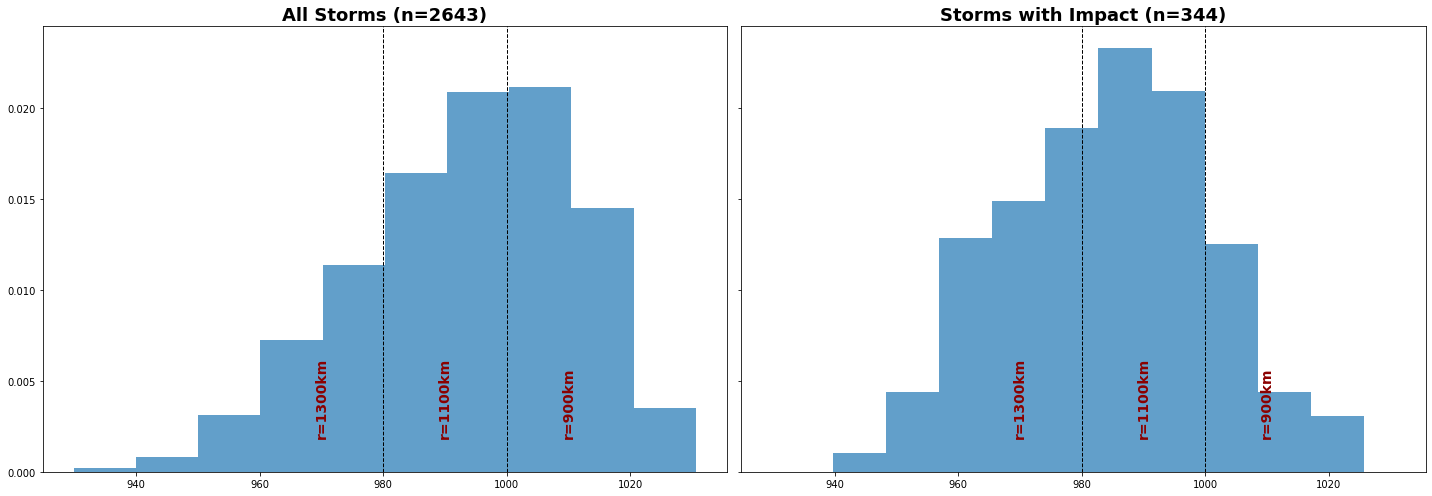

In [79]:
# Make 3 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
# for i in range(2):
#     axes[i]._autoscaleXon = False
#     axes[i]._autoscaleYon = False

# All set of tracks
axes[0].hist(df_info_storm.min_slp/100, density=True, alpha=0.7)
axes[0].set_title(f"All Storms (n={df_info_storm.storm_id.nunique()})", fontsize=18, fontweight="bold")

# Set of tracks with impact
axes[1].hist(df_info_storm_impact.min_slp/100, density=True, alpha=0.7)
axes[1].set_title(f"Storms with Impact (n={df_storm_impact.storm_id.nunique()})", fontsize=18, fontweight="bold")
    
# Add vertical lines for thresholds
thresholds = [980, 1000]
for ax in axes:
    for t in thresholds:
        ax.axvline(t, color="k", linestyle="--", linewidth=1)

    # Add text labels in each region
    ax.text(970, 0.002, "r=1300km", ha="center", fontsize=14, fontweight="bold", color="darkred", rotation=90)
    ax.text(990, 0.002, "r=1100km", ha="center", fontsize=14, fontweight="bold", color="darkred", rotation=90)
    ax.text(1010, 0.002, "r=900km",  ha="center", fontsize=14, fontweight="bold", color="darkred", rotation=90)
#     ax.text(1005,0.002, "r=700km",  ha="center", fontsize=14, fontweight="bold", color="darkred", rotation=90)

fig.tight_layout()

fig.savefig(path_save_fig+"Track_analysis/"+f"distribution_min_slp.png", 
            transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"Track_analysis/"+f"distribution_min_slp.svg", 
            format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"Track_analysis/"+f"distribution_min_slp.pdf", 
            format="pdf", bbox_inches="tight", dpi=300, transparent=True)

plt.show()

# Tracks with impact which would have been missed 

In [6]:
PATHS_TRACKS_FILT = '/home/estimr3/lhasbini/data_storm/priestley/convert_TE/NH_FILT/'
df_info_storm_filt                       = pd.read_csv(PATHS_TRACKS_FILT+"tracks_FILT_1979-2023_info.csv", encoding='utf-8')
df_info_storm_filt['storm_landing_date'] = pd.to_datetime(df_info_storm['storm_landing_date'])
df_storm_filt                            = pd.read_csv(PATHS_TRACKS_FILT+"tracks_FILT_1979-2023.csv", encoding='utf-8')



In [73]:
missing_storms = [s for s in stormi_impact if s not in df_info_storm_filt["storm_id"].values]
print(f"{len(missing_storms)} storms not present in the filtered tracking set")

missing_storms_clust = list(set(missing_storms) & set(df_info_mult_cluster_test["storm_id"]))
print(f"{len(missing_storms_clust)} storms not present in the filtered tracking set but in cluster")

107 storms not present in the filtered tracking set
52 storms not present in the filtered tracking set but in cluster


In [53]:
# stormi_impact[230:]

In [40]:
stormi_med = ['2017-11-12 00:00:00_-5.846039000000019_50.297691', '2018-01-20 06:00:00_-4.150695999999982_50.207462', '2019-02-01 12:00:00_-7.2240300000000275_44.902554', '2019-11-24 18:00:00_-6.8357540000000085_59.512745', 
              '2019-12-20 00:00:00_-4.658996999999999_43.020866', '2020-02-03 18:00:00_-2.560302999999976_48.930256', '2021-01-22 00:00:00_-4.588378999999975_42.935963', '2022-03-30 12:00:00_-0.2960509999999772_54.912758']

In [52]:
stormi_sw = ['2017-12-31 12:00:00_-6.045563000000016_40.077637', '2019-01-29 06:00:00_-9.27072099999998_47.925774', '2019-11-04 06:00:00_-7.135741999999993_51.540363', 
             '2019-12-12 18:00:00_-5.205933000000016_53.233566', '2019-12-21 18:00:00_-6.01724200000001_48.685242', '2020-03-03 06:00:00_-8.832672000000002_46.207809', '2023-11-04 18:00:00_-5.71875_49.128242']

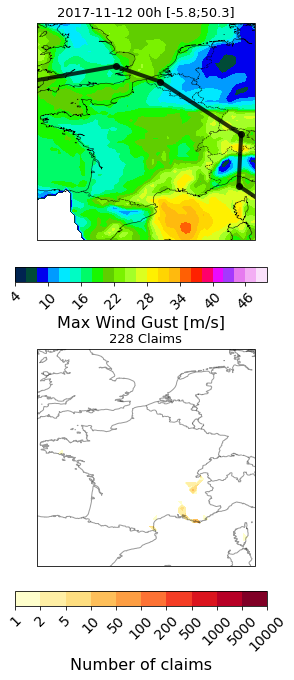

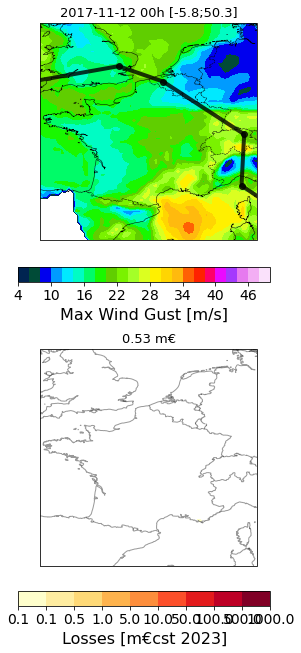

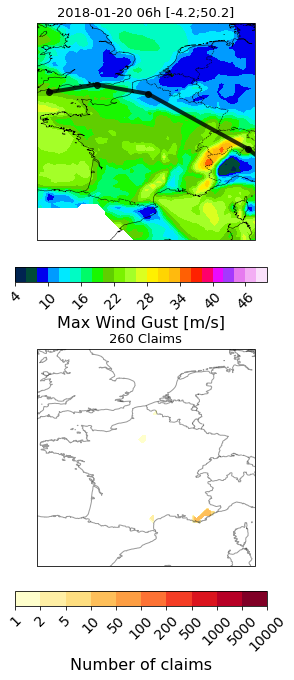

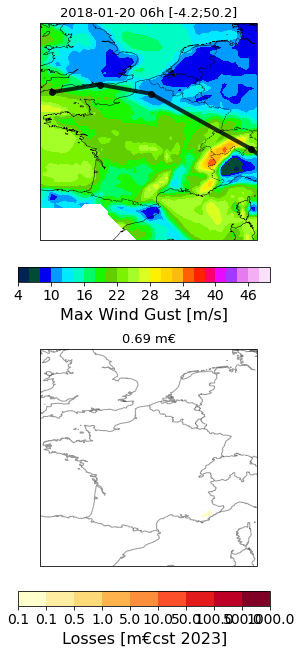

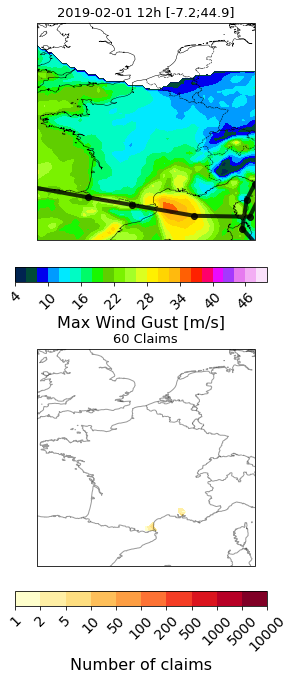

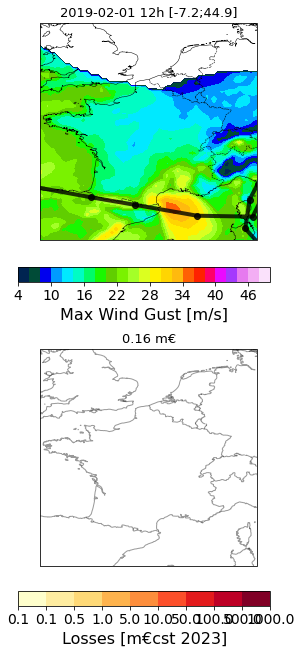

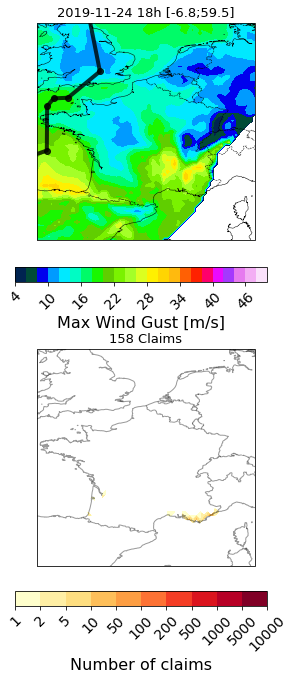

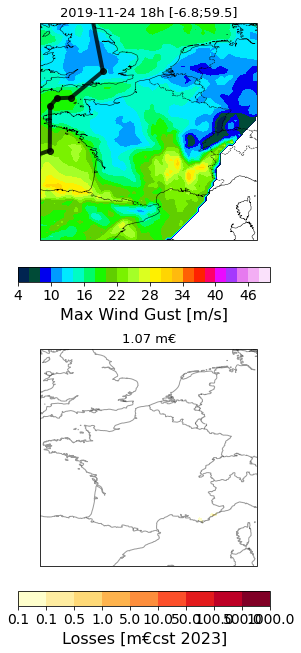

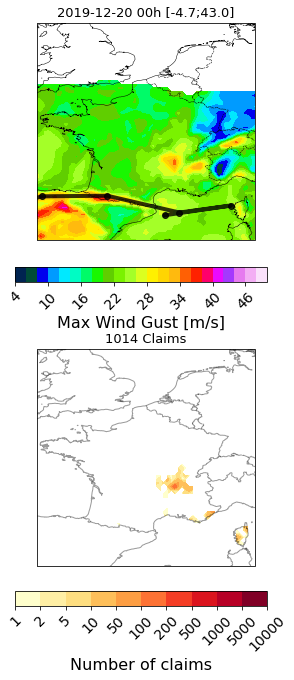

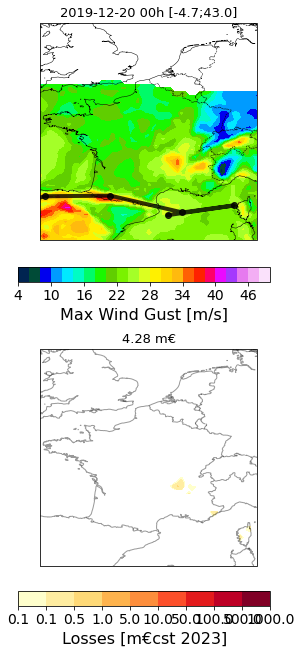

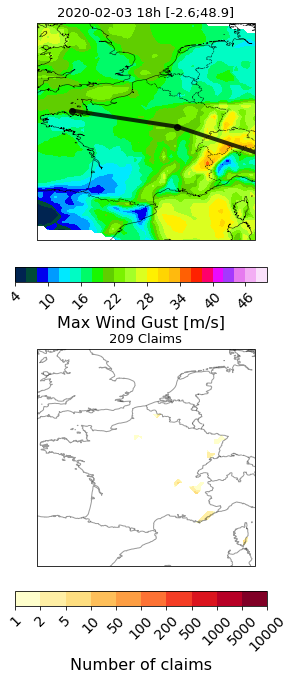

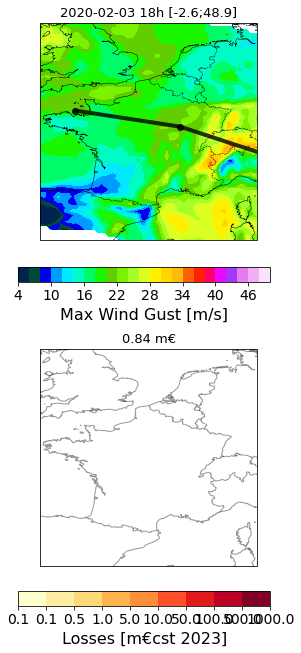

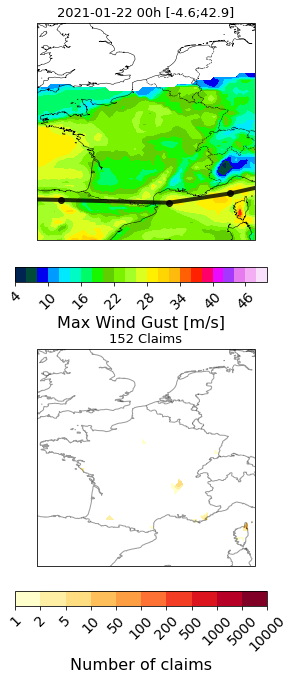

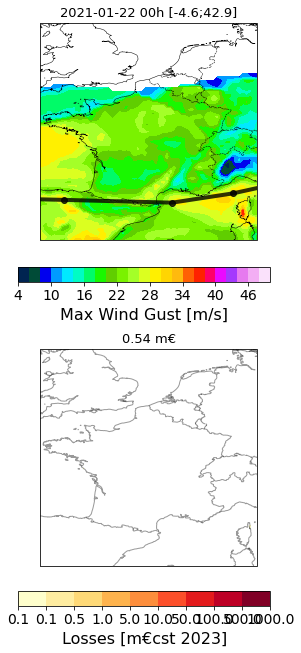

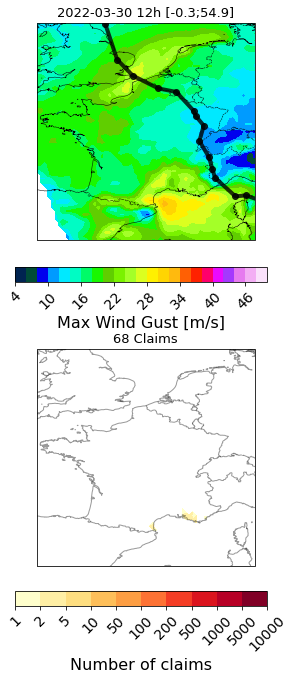

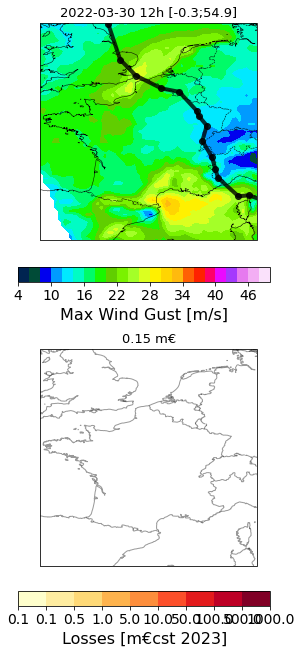

In [54]:
for stormi in stormi_med : 
    fct_plot_claims.plot_storm_wind_nbclaims_xr(df_storm, sinclim_025_xr, stormi, PATH_FOOTPRINTS, save=True, path_save_fig = path_save_fig+"Stormi_Med/", method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")
    fct_plot_claims.plot_storm_wind_losses_xr_025(df_storm, sinclim_025_xr, stormi, PATH_FOOTPRINTS, save=True, path_save_fig = path_save_fig+"Stormi_Med/", method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")

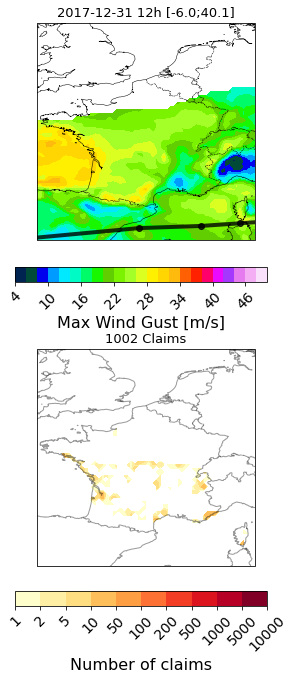

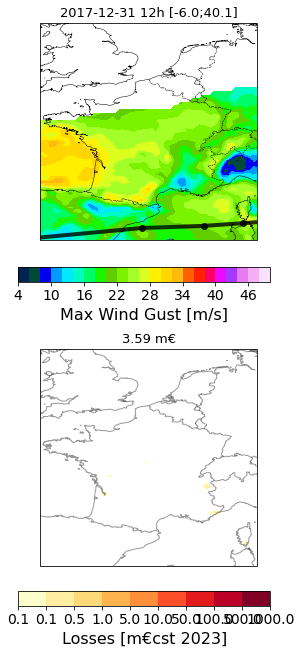

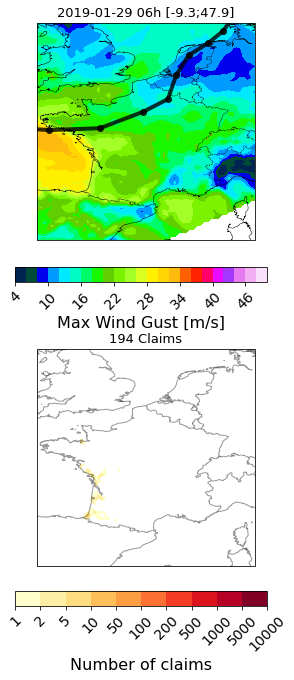

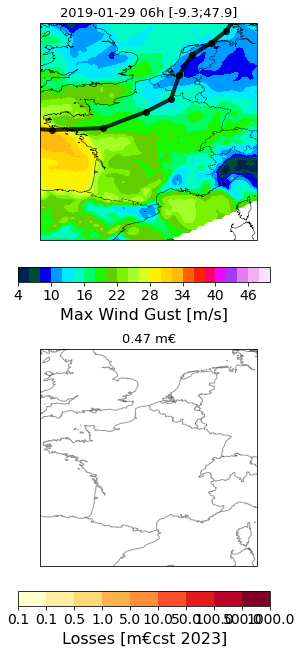

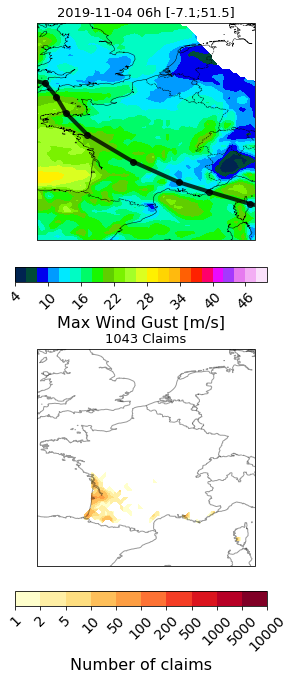

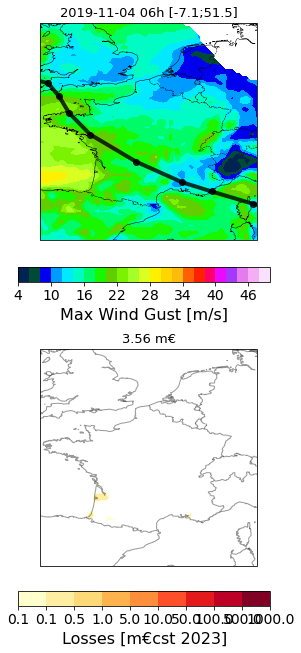

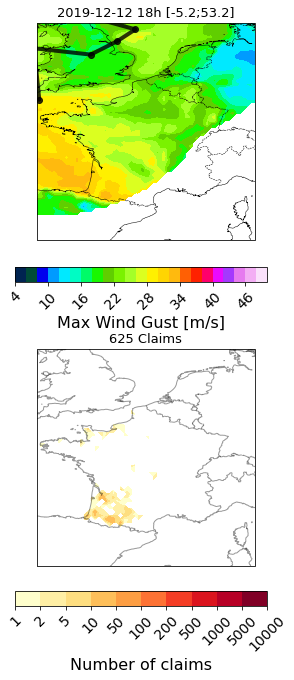

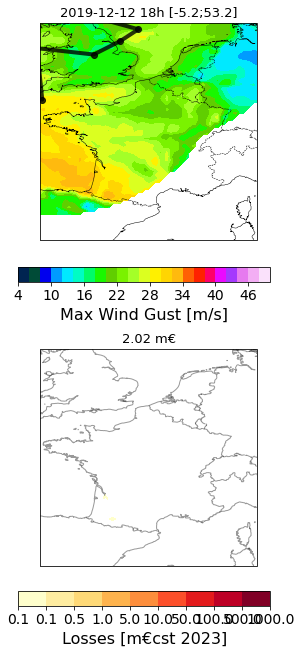

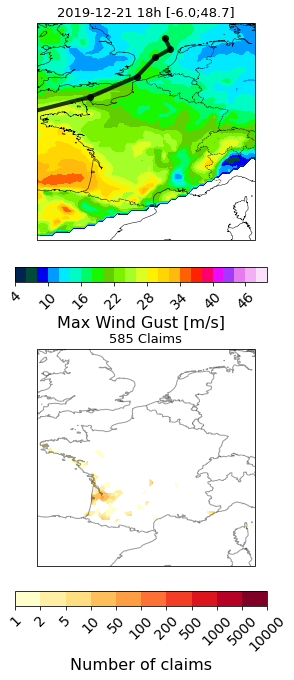

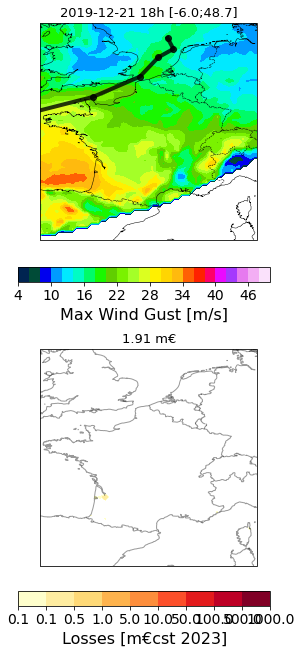

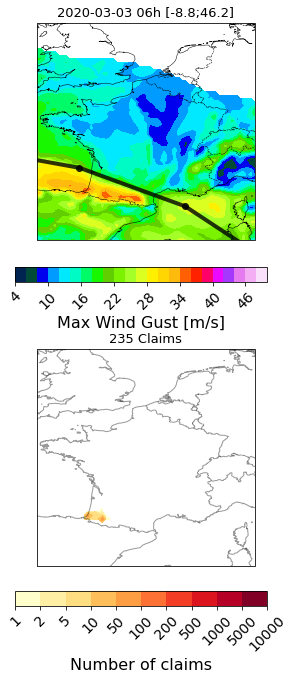

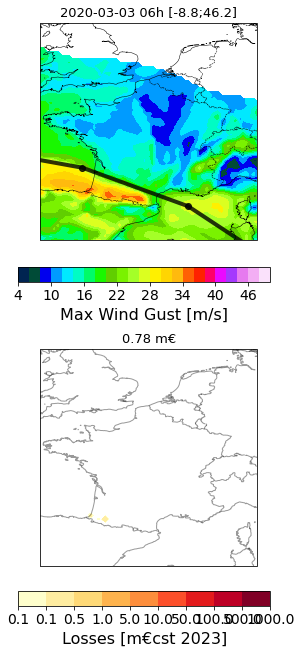

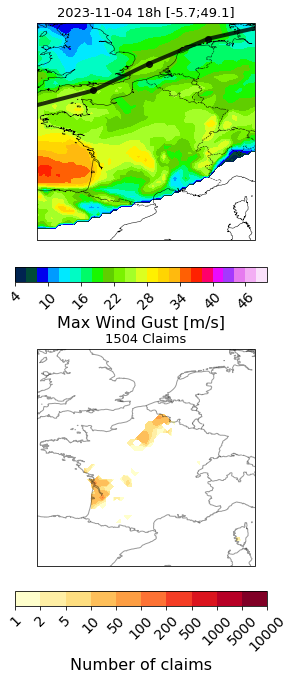

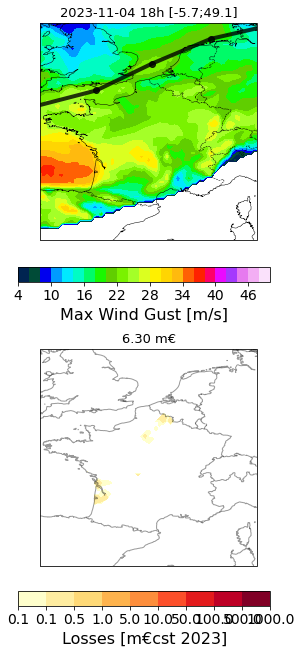

In [55]:
for stormi in stormi_sw : 
    fct_plot_claims.plot_storm_wind_nbclaims_xr(df_storm, sinclim_025_xr, stormi, PATH_FOOTPRINTS, save=True, path_save_fig = path_save_fig+"Stormi_SouthWest/", method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")
    fct_plot_claims.plot_storm_wind_losses_xr_025(df_storm, sinclim_025_xr, stormi, PATH_FOOTPRINTS, save=True, path_save_fig = path_save_fig+"Stormi_SouthWest/", method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")

In [74]:
#Interesting cases 
# '1998-01-02 06:00:00_-5.044219999999996_49.644596'
# '2001-02-08 00:00:00_-4.539917000000003_48.94059'
# '2001-11-09 12:00:00_-6.180297999999993_38.011509'

storm_case_study = missing_storms[0]#'2018-01-01 06:00:00_-8.959900000000005_49.360245'
print(storm_case_study)

1998-01-02 06:00:00_-5.044219999999996_49.644596


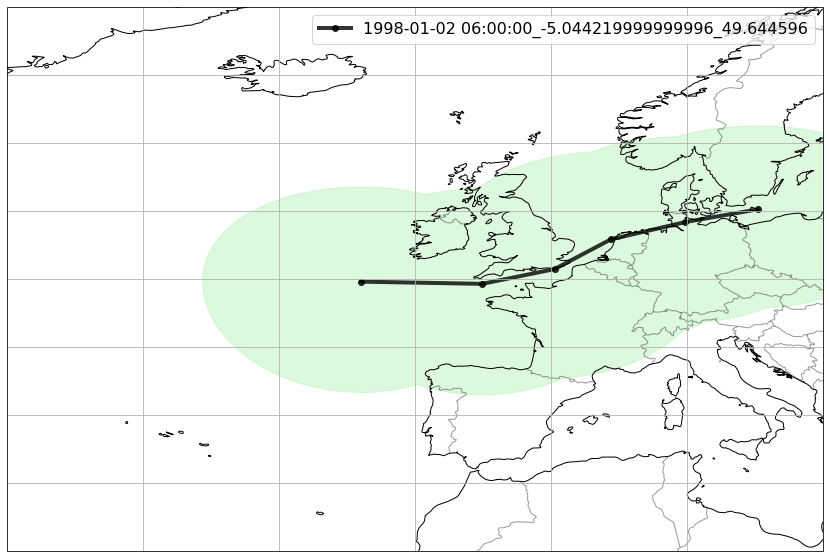

In [75]:
stormi_main = storm_case_study
df_info_plot = df_info_storm.loc[df_info_storm.storm_id==stormi_main]
df_plot = df_storm.loc[df_storm.storm_id==stormi_main]

#Prepare buffer
gdf_tracks = gpd.GeoDataFrame(
        df_plot,
        geometry=gpd.points_from_xy(df_plot.lon, df_plot.lat),
        crs="EPSG:4326"
    )
gdf_tracks['buffer'] = gdf_tracks.to_crs(epsg=3395).geometry.buffer(1300 * 1000).to_crs(epsg=4326)
spatial_index = gdf_tracks.sindex

polygons = []
fig = plt.figure(figsize=[15, 10])
ax = plt.subplot(1, 1, 1, projection = proj)
ax.set_extent([-40, 20, 30, 70], crs=proj)
ax._autoscaleXon = False
ax._autoscaleYon = False

#Buffer the storm 
storm_buffer = gdf_tracks.loc[gdf_tracks['storm_id'] == stormi_main, 'buffer'].values
union_buffer = unary_union(storm_buffer)
if isinstance(union_buffer, MultiPolygon):
    print(len(union_buffer))
    #polygons.append(union_buffer[0])
    union_buffer = union_buffer[1]
else :
    polygons.append(union_buffer)

#Plot the trajectory and the buffer
x, y = union_buffer.exterior.xy

ax.plot(df_plot['lon'], df_plot['lat'], '-o', alpha = 0.8, color = "black", 
    linewidth=4, label=stormi_main)
plt.fill(x, y, alpha=0.3, color='lightgreen')

geo_series = gpd.GeoSeries(polygons)

ax.coastlines()
ax.gridlines()
ax.add_feature(cf.BORDERS, linestyle='-', alpha=0.4)
ax.legend(fontsize=16)
fig.savefig(path_save_fig+"Track_storm_"+str(stormi_main)+".png", transparent=True, bbox_inches='tight')

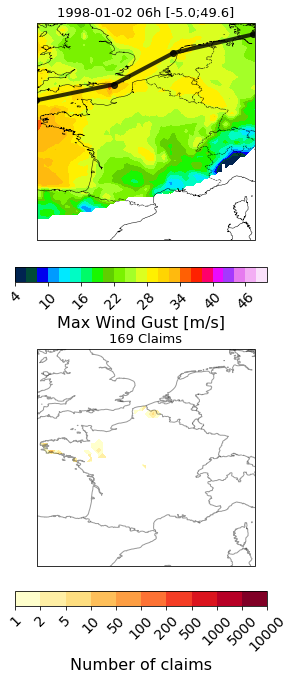

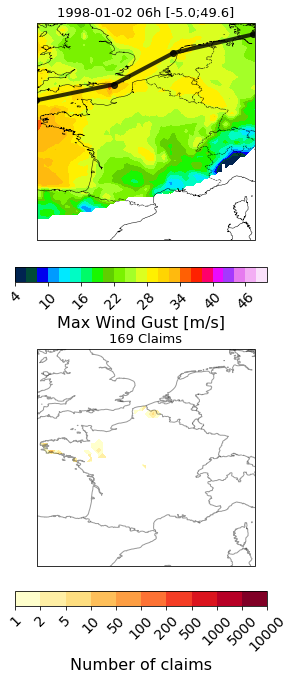

In [78]:
fct_plot_claims.plot_storm_wind_nbclaims_xr(df_storm, sinclim_025_xr, storm_case_study, PATH_FOOTPRINTS, save=True, path_save_fig = path_save_fig, method=window+"_unique-"+method+"_min"+str(min_claim)+"_priestley_ALL_"+period+"_r1300")